# Métodos inciais - Reconhecimento Biométrico das Mãos

In [10]:
import numpy as np 
import imageio
import math
import matplotlib.pyplot as plt

# Enable this for iteractive mode in Jupyter Notebook plots
# %matplotlib notebook

Carrega a imagem a ser reconhecida por biometria

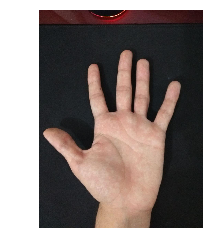

In [11]:
image = imageio.imread("handDatabase/person002_001.jpg")
plt.axis('off')
plt.imshow(image)
plt.show()

Implementa as funções para cálculo de variáveis utilizadas no algoritmo de Otsu

In [12]:
# Calculates a weigh for a class
def weigh(M, x1, x2, hist):
	return (1/M)*np.sum(hist[x1:x2])

# Calculates mean for a class
def mean(x1, x2, hist):

	a = 0 

	for i in range(x1, x2):
		a = a+(i*hist[i])

	if np.sum(hist[x1:x2]) != 0:
		return a/(np.sum(hist[x1:x2]))
	else: 
		return 0

# Calculates variance for a class
def variance(x1, x2, mean, hist):

	a = 0

	for i in range(x1, x2):
		a = a+(math.pow(i-mean, 2)*hist[i])

	if np.sum(hist[x1:x2]) != 0:
		return a/(np.sum(hist[x1:x2]))
	else: 
		return 0

Transformação da imagem RGB para escala de cinza

In [ ]:
def grayTransform(img):
	return np.dot(img, [0.299, 0.587, 0.114])

gray = grayTransform(image).astype(int)

plt.axis('off')
plt.imshow(gray, cmap=plt.get_cmap('gray'))
plt.show()

Implementação do algoritmo de Otsu, que detecta automaticamente o melhor thresholding a ser utilizado na imagem para conversão da imagem para binário

In [ ]:
def otsuThresholding(img):

	# Computing histogram
	hist, bin_edges = np.histogram(img, bins='auto');
	# Converts array with edges to int
	bin_edges = bin_edges.astype(int)

	# New array to histogram
	histogram = np.zeros(255)

	# Fills new histogram
	for x in range(hist.size):
		histogram[bin_edges[x]] = hist[x]

	# Converts to int
	histogram = histogram.astype(int)

	intraclassVar = np.zeros(histogram.size)

	# Intra-class variance for each intensity
	for L in range(histogram.size):
		
		# Weigh for class A, sum of frequencies from 0 to L-1
		weighA = weigh(img.shape[0]*img.shape[1], 0, L, histogram)
		# Mean for class A
		meanA = mean(0, L+1, histogram)
		# Variance for class A
		varA = variance(0, L+1, meanA, histogram)

		# Weigh for class B, sum of frequencies from L to last item
		weighB = weigh(img.shape[0]*img.shape[1], L, histogram.size, histogram)
		# Mean for class B
		meanB = mean(L, histogram.size, histogram)
		# Variance for class B
		varB = variance(L, histogram.size, meanB, histogram)
		
		# Stores intraclass variance calculated
		intraclassVar[L] = weighA*varA + weighB*varB

		# Set the min value 
		if L is 0:
			minValue = intraclassVar[L]
		elif L != 0 and minValue > intraclassVar[L]: 
			minValue = intraclassVar[L] 

	# Returns the optimal thresholding
	return list(intraclassVar).index(minValue)

thresholding = otsuThresholding(gray)

Realiza a conversão da imagem para binário utilizando o thresholding obtido

In [ ]:
def binaryTransform(img, thresholding):

	binImg = np.zeros(img.shape)

	# Sets image values according to chosen thresholding
	for x in range(img.shape[0]):
		for y in range(img.shape[1]):
			if img[x,y] > thresholding: binImg[x,y] = 1

	plt.axis('off')
	plt.imshow(binImg, cmap=plt.get_cmap('gray'))
	plt.show()

	return binImg

binImg = binaryTransform(gray, thresholding)

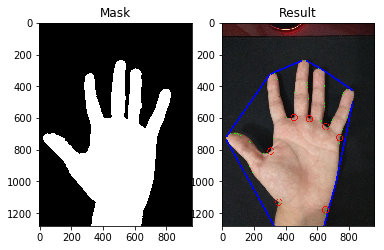

In [9]:
import cv2

def edgeDetection(binImg, image):

    binary = binImg.astype(np.uint8)
    
    # Reads the binary image
    img = image.astype(np.uint8)
    
    # Finding contours
    im2, contours, hierarchy = cv2.findContours(binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    # Finding the biggest contour
    cnt = None
    cntArea = 0
    for i in range(len(contours)):
        if cv2.contourArea(contours[i]) > cntArea:
            cnt = contours[i]
            cntArea = cv2.contourArea(contours[i])
    
    # Drawing the contour in the original image
    mask = np.zeros_like(binary)
    cv2.drawContours(mask, [cnt], -1, (255), -1)
    cv2.drawContours(img, cnt, -1, (0,255,0), 1)
    
    #generating convex hull and convexity defects
    hull = cv2.convexHull(cnt, returnPoints = False)
    old_defects = cv2.convexityDefects(cnt, hull)
    
    #iterating through defects and checking for defects that are too small
    defects = []
    for i in range(old_defects.shape[0]):
        s,e,f,d = old_defects[i,0]
        # if distance from defect to hull is smaller than 4000, continue
        if d < 4000:
            continue;
        # drawing the defects and the hull
        start = tuple(cnt[s][0])
        end = tuple(cnt[e][0])
        far = tuple(cnt[f][0])
        cv2.line(img,start,end,[0,0,255],9)
        cv2.circle(img,far,20,[255,0,0], 3)
        # adding the big defects to a new array
        defects.append(old_defects[i])
        
    #returns the original image with everything drawed, the binary mask, the contour of the mask, the convex hull and the convex defects
    return (img, mask, cnt, hull, defects)

res = edgeDetection(binImg, image)

plt.subplot(121)
plt.title('Mask')
plt.imshow(res[1], cmap='gray')


plt.subplot(122)
plt.title('Result')
plt.imshow(res[0])

plt.show()